We are two UIUC students from Indonesia that is attempting to predict air quality trends in Jakarta. 

## Importing Libraries

In [397]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from imblearn.combine import SMOTEENN


## Cleaning The Data

In [398]:
df = pd.read_csv('dataset/airquality-data.csv')
df.drop(columns=['periode_data'])
df

,periode_data,tanggal,pm_10,pm_duakomalima,so2,co,o3,no2,max,critical,categori,lokasi_spku
0,202212,2022-12-02,60,94,52,18,42,30,94,"PM2,5",SEDANG,DKI4
1,202212,2022-12-03,60,100,52,16,49,31,100,"PM2,5",SEDANG,DKI4
2,202212,2022-12-04,65,95,52,19,45,34,95,"PM2,5",SEDANG,DKI4
3,202212,2022-12-05,74,117,52,19,48,33,117,"PM2,5",TIDAK SEHAT,DKI4
4,202212,2022-12-06,70,107,49,24,41,44,107,"PM2,5",TIDAK SEHAT,DKI4
...,...,...,...,...,...,...,...,...,...,...,...,...
360,202201,2022-01-16,67,102,47,20,65,32,102,"PM2,5",TIDAK SEHAT,DKI5
361,202201,2022-01-15,55,69,51,15,68,29,69,"PM2,5",SEDANG,DKI3
362,202201,2022-01-14,46,63,48,15,63,32,63,"PM2,5",SEDANG,DKI2
363,202201,2022-01-13,38,62,52,15,63,32,63,O3,SEDANG,DKI2


Translating the Data

In [399]:
translations = {
    'periode_data': 'Data Period',
    'tanggal' : 'Date',
    'pm_10' : 'PM 10',
    'so2' : 'SO2',
    'co' : 'CO',
    'o3' : 'O3',
    'no2' : 'NO2',
    'max' : 'Max',
    'critical' : 'Critical',
    'pm_duakomalima' : 'PM 2.5',
    'lokasi_spku' : 'Station Location',
    'categori' : 'Category'
}
df.rename(columns=translations, inplace=True)

category_translation = {
    'SEDANG': 'MODERATE',
    'TIDAK SEHAT' : 'POOR',
    'BAIK' : 'GOOD',
}
df['Category'] = df['Category'].replace(category_translation)

station_location_translation = {
    '0' : '0',
    'DKI1' : 'DKI1 (Bunderan HI)',
    'DKI2' : 'DKI2 (Kelapa Gading)',
    'DKI3' : 'DKI3 (Jagakarsa)',
    'DKI4' : 'DKI4 (Lubang Buaya)',
    'DKI5' : 'DKI5 (Kebon Jeruk)'
}

df['Station Location'] = df['Station Location'].replace(station_location_translation)
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
0,202212,2022-12-02,60,94,52,18,42,30,94,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
1,202212,2022-12-03,60,100,52,16,49,31,100,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2,202212,2022-12-04,65,95,52,19,45,34,95,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
3,202212,2022-12-05,74,117,52,19,48,33,117,"PM2,5",POOR,DKI4 (Lubang Buaya)
4,202212,2022-12-06,70,107,49,24,41,44,107,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
360,202201,2022-01-16,67,102,47,20,65,32,102,"PM2,5",POOR,DKI5 (Kebon Jeruk)
361,202201,2022-01-15,55,69,51,15,68,29,69,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202201,2022-01-14,46,63,48,15,63,32,63,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
363,202201,2022-01-13,38,62,52,15,63,32,63,O3,MODERATE,DKI2 (Kelapa Gading)


finding coordinate for each station

Translating category column

In [400]:
df = df.sort_values(by = 'Date', ascending = True).reset_index(drop = True)
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
0,202202,2020-02-01,64,89,52,13,76,21,89,"PM2,5",MODERATE,DKI3 (Jagakarsa)
1,202202,2020-02-02,66,101,47,22,64,26,101,"PM2,5",POOR,DKI4 (Lubang Buaya)
2,202202,2020-02-03,58,99,48,20,65,33,99,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
3,202202,2020-02-04,54,72,46,12,68,27,72,"PM2,5",MODERATE,DKI3 (Jagakarsa)
4,202202,2020-02-05,43,62,53,18,55,30,62,"PM2,5",MODERATE,DKI5 (Kebon Jeruk)
...,...,...,...,...,...,...,...,...,...,...,...,...
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)
363,202212,2022-12-30,40,64,57,21,17,24,64,"PM2,5",MODERATE,DKI4 (Lubang Buaya)


In [401]:
# remove incorrect date data
df2 = df.drop(364)

# remove 2020 data
df3 = df2.drop(range(0,28))
df = df3
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)


In [402]:
df.replace('null', np.NaN, inplace=True)
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)


## Understanding the data

In [403]:
df.head()

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)


In [404]:
df.tail()

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)
363,202212,2022-12-30,40,64,57,21,17,24,64,"PM2,5",MODERATE,DKI4 (Lubang Buaya)


In [405]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 28 to 363
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Data Period       336 non-null    int64 
 1   Date              336 non-null    object
 2   PM 10             336 non-null    int64 
 3   PM 2.5            336 non-null    int64 
 4   SO2               336 non-null    int64 
 5   CO                336 non-null    int64 
 6   O3                336 non-null    int64 
 7   NO2               336 non-null    int64 
 8   Max               336 non-null    int64 
 9   Critical          335 non-null    object
 10  Category          336 non-null    object
 11  Station Location  336 non-null    object
dtypes: int64(8), object(4)
memory usage: 31.6+ KB


In [406]:
df.shape

(336, 12)

In [407]:
df.describe()

,Data Period,PM 10,PM 2.5,SO2,CO,O3,NO2,Max
count,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000,336.000000
mean,202206.886905,60.324405,93.717262,48.125000,18.383929,57.553571,28.791667,94.625000
std,3.319640,13.234018,24.416421,4.443593,7.170727,23.897857,8.710504,24.492628
min,202201.000000,23.000000,40.000000,37.000000,7.000000,15.000000,6.000000,50.000000
25%,202204.000000,53.000000,76.000000,45.000000,14.000000,39.000000,23.000000,76.000000
50%,202207.000000,60.000000,92.000000,49.000000,17.000000,53.000000,28.000000,93.000000
75%,202210.000000,69.250000,112.000000,51.000000,21.000000,72.250000,33.250000,112.000000
max,202212.000000,95.000000,165.000000,62.000000,55.000000,181.000000,52.000000,181.000000


In [408]:

df = df[df.Critical != 'null']
df

,Data Period,Date,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
28,202201,2022-01-01,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
29,202201,2022-01-02,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
30,202201,2022-01-03,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
31,202201,2022-01-04,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
32,202201,2022-01-05,95,165,53,18,55,32,165,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...,...
359,202212,2022-12-26,43,62,58,54,25,27,62,"PM2,5",MODERATE,DKI2 (Kelapa Gading)
360,202212,2022-12-27,36,47,58,42,20,18,58,SO2,MODERATE,DKI2 (Kelapa Gading)
361,202212,2022-12-28,46,66,57,41,15,19,66,"PM2,5",MODERATE,DKI3 (Jagakarsa)
362,202212,2022-12-29,23,50,57,12,16,15,57,SO2,MODERATE,DKI2 (Kelapa Gading)


The dataset used in this model is taken from the Jakarta Open Data Website. It contains information about the Air Pollution Quality Index (APSI) measured by 5 air quality monitoring systems (AQMS) in the DKI Jakarta province for the year 2022.

Dataset components:

1. Date: Data of air quality measurement
2. PM 10: Particulate matter, one of the monitored parameters
3. PM 2.5: Particulate matter with a size below 2.5 microns, one of the monitored parameters
4. SO2: Sulfide, one of the monitored parameters
5. CO: Carbon Monoxide, one of the monitored parameters
6. O3: Ozone, one of the monitored parameters
7. NO2: Nitrogen dioxide, one of the monitored parameters
8. Max: Highest measurement value from all parameters measured at the same time
9. Critical: Parameter with the highest measurement value
10. Station Location: Air Quality Monitoring Systems Location

<Axes: xlabel='Date'>

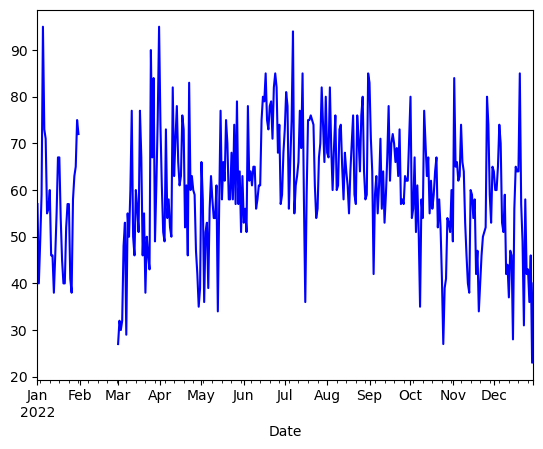

In [409]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date', inplace=True)
numerical_columns = df.select_dtypes(include=['number']).columns
df_resampled = df[numerical_columns].resample('D').mean()
df_resampled['PM 10'].plot(kind='line', color='blue')

# Handling Outliers

In [410]:
numerical_cols = df.select_dtypes(include=['number']).columns

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# call the function for each numerical column in the dataframe
for col in numerical_cols:
    df = remove_outliers(df, col)
df

,Data Period,PM 10,PM 2.5,SO2,CO,O3,NO2,Max,Critical,Category,Station Location
Date,,,,,,,,,,,
2022-01-01,202201,57,85,48,13,34,18,85,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-01-02,202201,40,70,45,10,36,11,70,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-01-03,202201,49,80,49,13,37,21,80,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-01-04,202201,59,102,51,14,51,26,102,"PM2,5",POOR,DKI4 (Lubang Buaya)
2022-01-06,202201,73,117,53,16,48,42,117,"PM2,5",POOR,DKI4 (Lubang Buaya)
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-17,202212,65,98,52,30,38,45,98,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-12-18,202212,64,96,52,26,46,45,96,"PM2,5",MODERATE,DKI4 (Lubang Buaya)
2022-12-19,202212,64,99,57,28,39,48,99,"PM2,5",MODERATE,DKI4 (Lubang Buaya)


# Changing Categorical data to numerical data

In [411]:
df.Category.value_counts()

Category
MODERATE    194
POOR        113
Name: count, dtype: int64

In [412]:
mapping = {
    'GOOD': 0,
    'MODERATE' : 1,
    'POOR' : 2,
}
df['Target'] = df.Category.map(mapping)
df['Target'].value_counts()

Target
1    194
2    113
Name: count, dtype: int64

## Changing Target Variables

In [413]:
df.columns

Index(['Data Period', 'PM 10', 'PM 2.5', 'SO2', 'CO', 'O3', 'NO2', 'Max',
       'Critical', 'Category', 'Station Location', 'Target'],
      dtype='object')

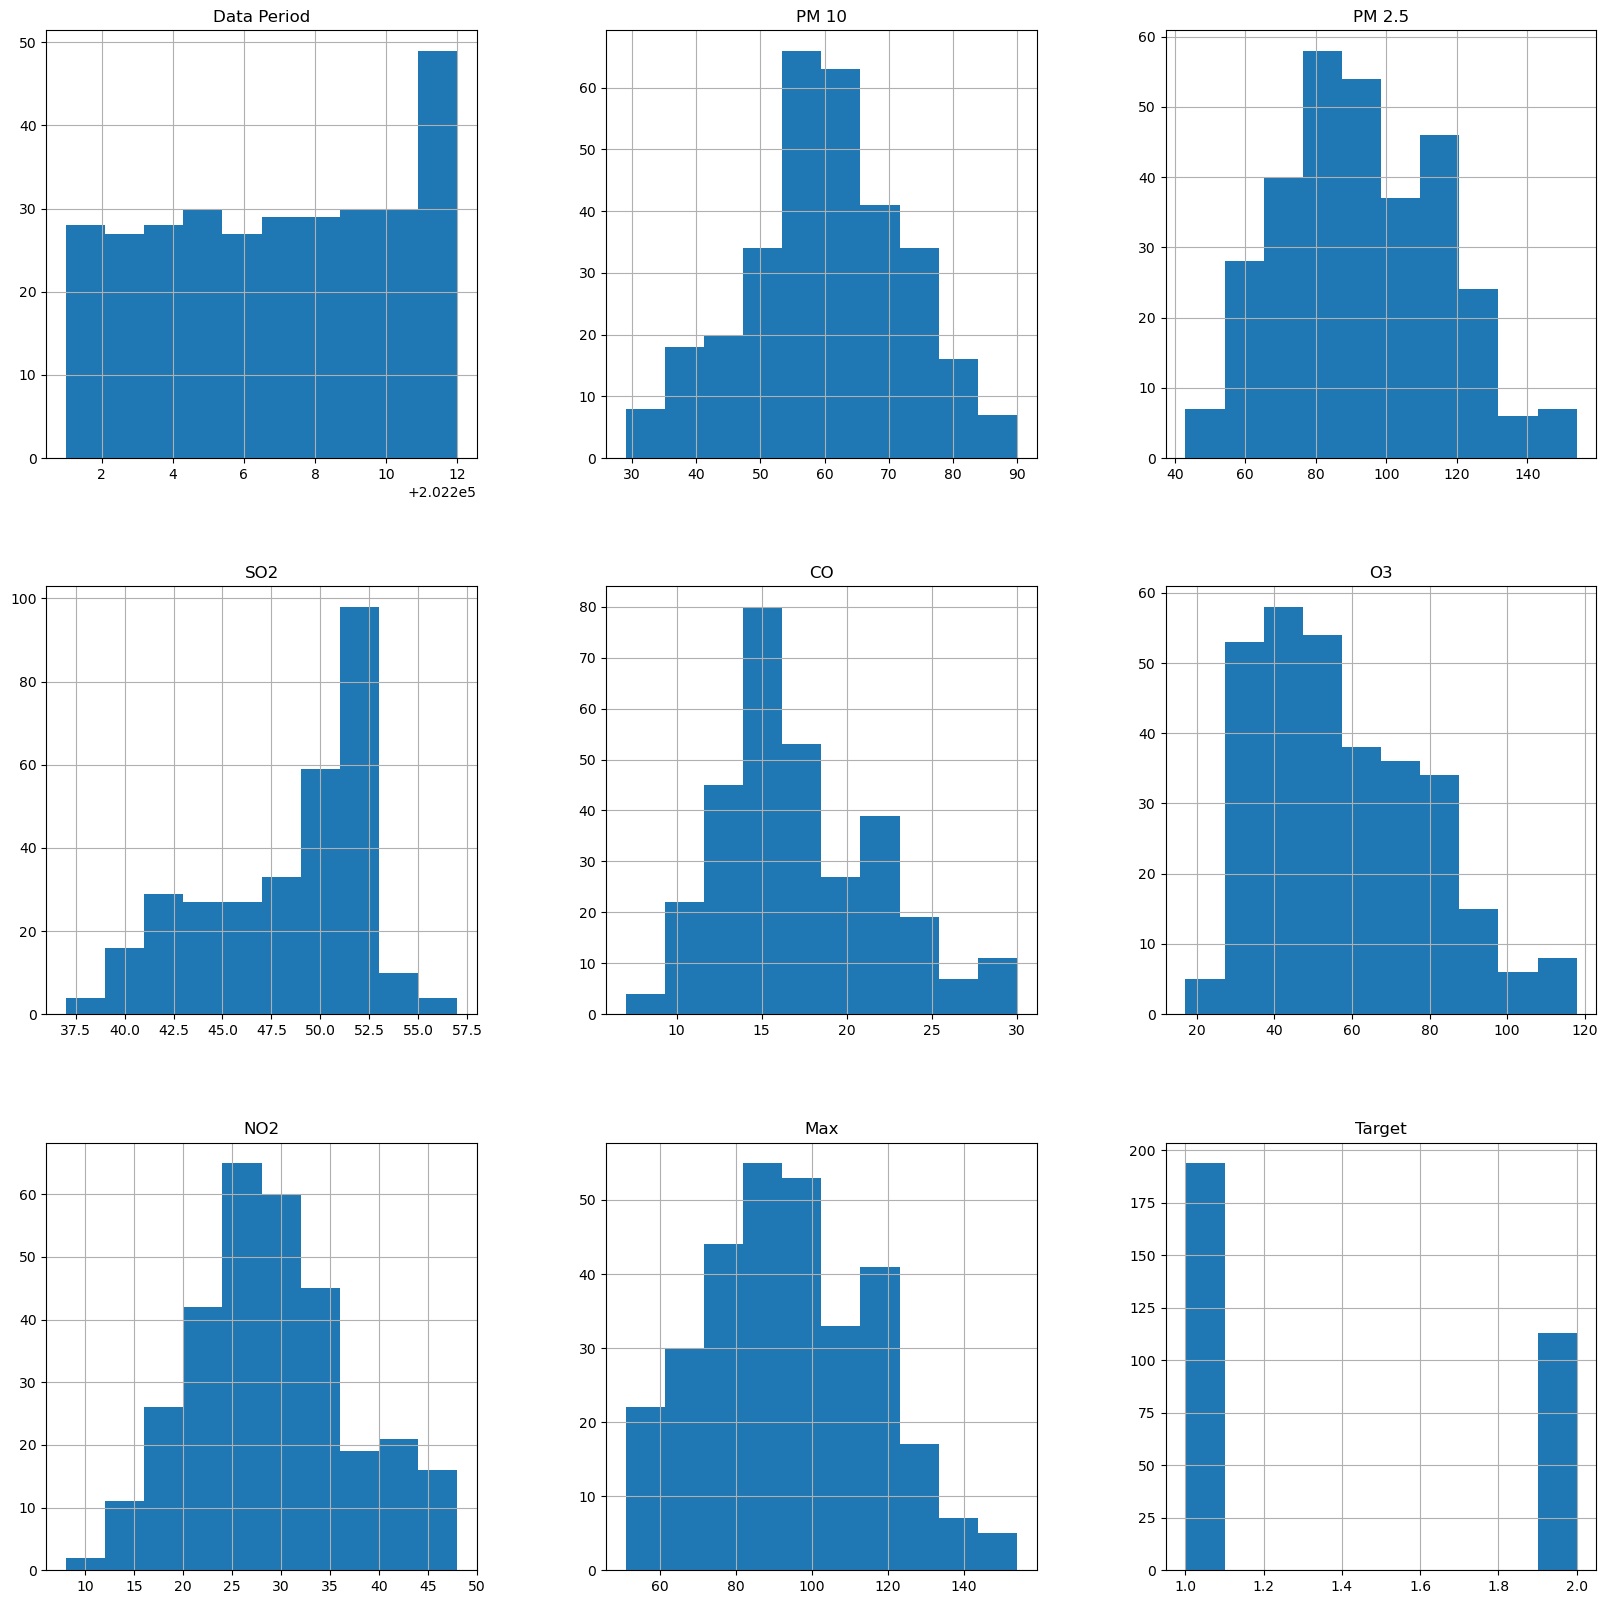

In [414]:
plot = df.hist(figsize = (20,20))

In [415]:
temp = df.reset_index().drop('Date', axis=1)
x = temp.drop(['Critical', 'Category', 'Target', 'Station Location', 'Data Period'], axis=1)
y = df['Target']
x

,PM 10,PM 2.5,SO2,CO,O3,NO2,Max
0,57,85,48,13,34,18,85
1,40,70,45,10,36,11,70
2,49,80,49,13,37,21,80
3,59,102,51,14,51,26,102
4,73,117,53,16,48,42,117
...,...,...,...,...,...,...,...
302,65,98,52,30,38,45,98
303,64,96,52,26,46,45,96
304,64,99,57,28,39,48,99
305,85,154,54,23,29,47,154


In [416]:
x.head(5)

,PM 10,PM 2.5,SO2,CO,O3,NO2,Max
0,57,85,48,13,34,18,85
1,40,70,45,10,36,11,70
2,49,80,49,13,37,21,80
3,59,102,51,14,51,26,102
4,73,117,53,16,48,42,117


In [417]:
y.head(5)

Date
2022-01-01    1
2022-01-02    1
2022-01-03    1
2022-01-04    2
2022-01-06    2
Name: Target, dtype: int64

In [418]:
temporary_target = y.value_counts()

# percentages
moderate = (temporary_target[1] / len(y)) * 100
poor = (temporary_target[2] / len(y)) * 100
total = moderate + poor

print(f"1: {moderate:.2f}%")
print(f"2: {poor:.2f}%")
print(f"Total: {total:.2f}%")


1: 63.19%
2: 36.81%
Total: 100.00%


In [419]:
sme = SMOTEENN(sampling_strategy='all', random_state=24)
x_res, y_res = sme.fit_resample(x, y)
y_res.value_counts()

Target
1    176
2    176
Name: count, dtype: int64

Checking distribution after the sampling

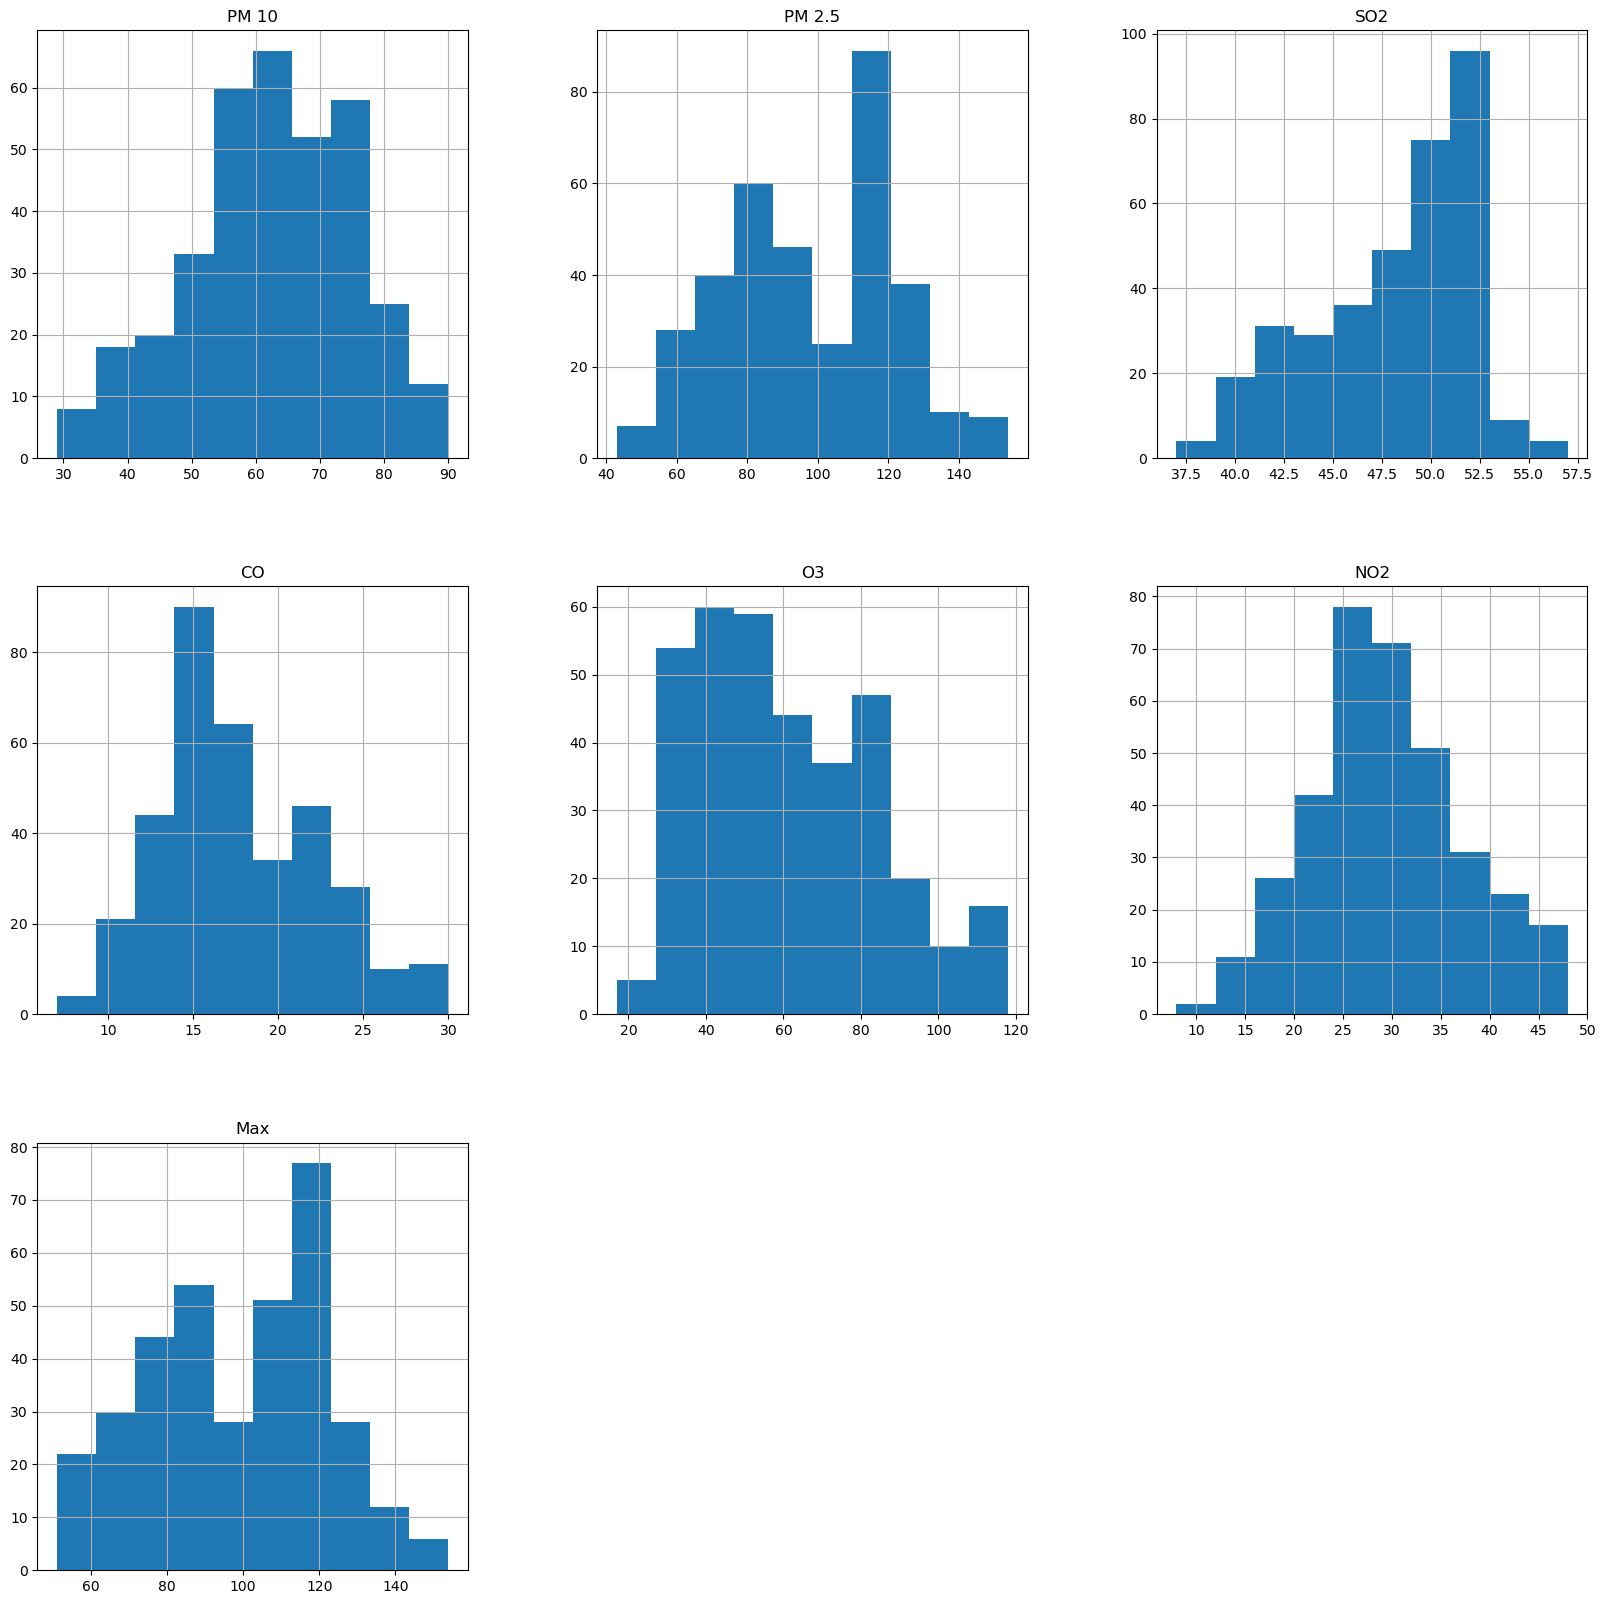

In [421]:
plot = x_res.hist(figsize = (20,20))

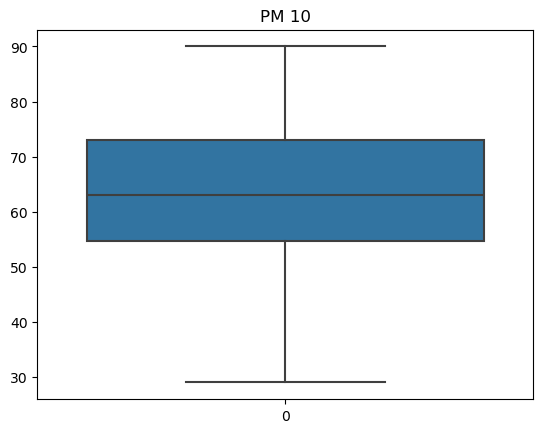

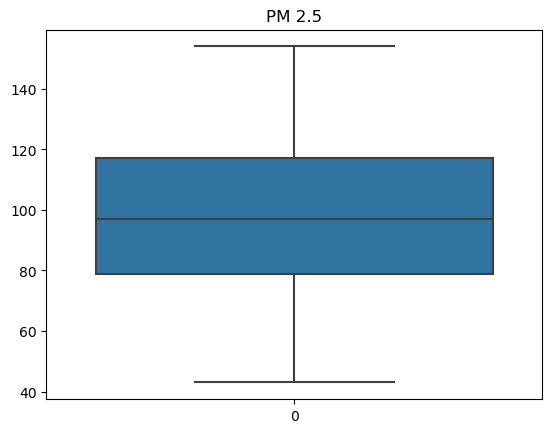

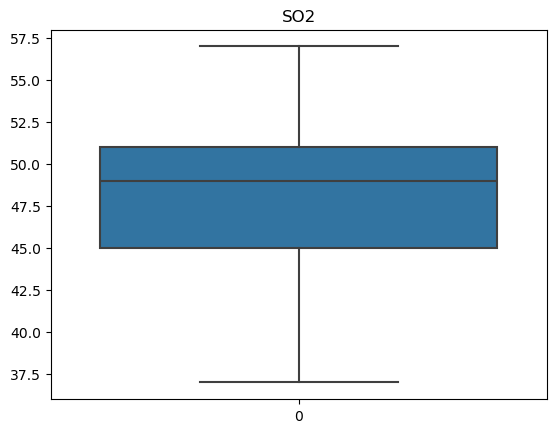

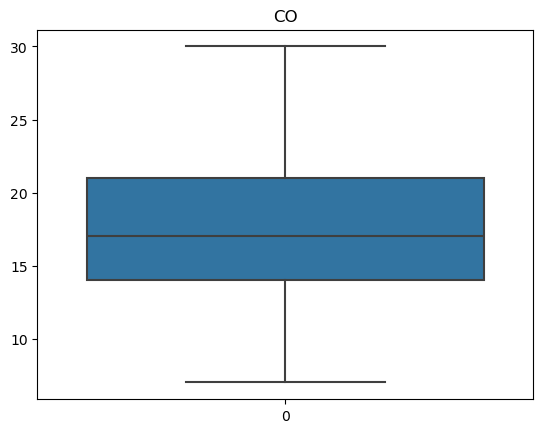

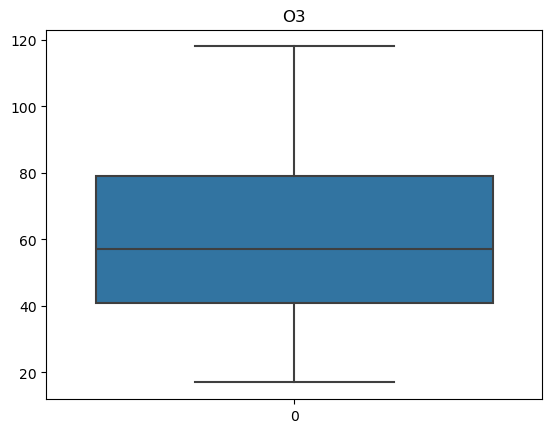

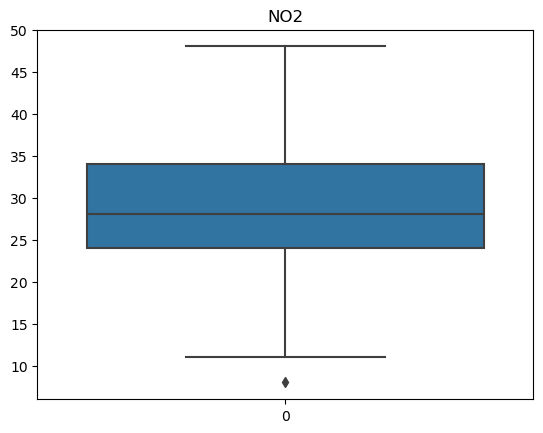

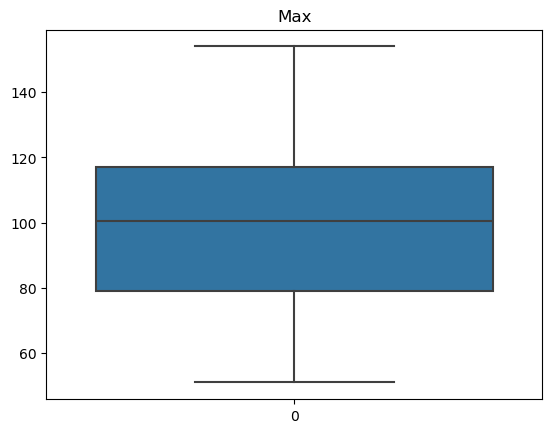

In [423]:
for i in x_res.columns:
    sns.boxplot(data=x_res[i])
    plt.title(i)
    plt.show()

In [429]:
x_res_noOutliers = remove_outliers(x_res)
print(len(x_res) - len(x_res_noOutliers))
print(len(x_res_noOutliers))
     

TypeError: remove_outliers() missing 1 required positional argument: 'column'

In [428]:
y_res = y_res[y_res.index.isin(x_res_noOutliers.index)]

NameError: name 'x_res_noOutliers' is not defined

## Split data for training and testing

In [ ]:

x_train, x_test, y_train, y_test = train_test_split(x_res_noOutliers, y_res,  
                                                    shuffle = True,
                                                    test_size=0.2, 
                                                    random_state=24)
